<a href="https://colab.research.google.com/github/Uthman-Abbas/Faster-R-CNN/blob/main/FRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Muhammad Usman Abbas
450498**


**Introduction:** The following guide is for implementing Faster R-CNN on a custom dataset using Google Colab. The dataset was prepared in Label Studio. The dataset was split into Test, Train And Validation sets with images and labels folders. There are two classes (White Pawn and Black Pawn) and T4 GPU was used to find the loss over 10 epochs. The minimum loss was found at 8 epochs. The performance metrics are shown at the end

**Step 1: Setup Environment in Google Colab**

In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torchvision
!pip install pytorch - lightning
!pip install fiftyone

Looking in indexes: https://download.pytorch.org/whl/cu118
ERROR: Invalid requirement: '-': Expected package name at the start of dependency specifier
    -
    ^


**Step 2: Give Path to Custom Dataset**

In [1]:
from google.colab import drive

drive.mount('/content/drive')

import os

os.chdir('/content/drive/MyDrive/Chess')

Mounted at /content/drive


Installing Libraries as we go

In [3]:
!pip install pycocotools

**Step 3: Load Faster R-CNN Pretrained Model**

In [4]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import os
import cv2
from PIL import Image

model = fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 173MB/s]


**Step 4: Load the Dataset**

In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T


class ChessPiecesDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.images = sorted(os.listdir(os.path.join(root, "images")))
        self.labels = sorted(os.listdir(os.path.join(root, "labels")))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.images[idx])
        label_path = os.path.join(self.root, "labels", self.labels[idx])
        image = Image.open(img_path).convert("RGB")

        boxes, labels = self.parse_polygon_label(label_path, image.size)

        # Skip images without valid annotations
        if len(boxes) == 0:
            return None

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.images)

    def parse_polygon_label(self, label_path, image_size):
        boxes, labels = [], []  # Correct initialization
        with open(label_path, "r") as f:
            for line in f:
                values = line.split()
                if len(values) < 9:
                    print(f"Skipping invalid line: {line.strip()}")
                    continue
                class_id = int(values[0])
                vertices = list(map(float, values[1:]))
                x_coords = vertices[0::2]
                y_coords = vertices[1::2]
                x_min = min(x_coords) * image_size[0]
                y_min = min(y_coords) * image_size[1]
                x_max = max(x_coords) * image_size[0]
                y_max = max(y_coords) * image_size[1]
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(class_id + 1)  # Add 1 if class IDs start from 0
        return boxes, labels


def collate_fn(batch):
    # Filter out None samples
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        raise ValueError("All samples in the batch are None. Check your dataset.")
    return tuple(zip(*batch))

**Step 5: Transform Images into Tensors**

In [ ]:
transforms = T.Compose([
    T.ToTensor(),  # Convert PIL Image to Tensor
])


**Step 6: Initialise Train, Validation and Test Datasets**

In [ ]:
train_dataset = ChessPiecesDataset('/content/drive/MyDrive/Chess/train', transforms=transforms)
val_dataset = ChessPiecesDataset('/content/drive/MyDrive/Chess/val', transforms=transforms)
test_dataset = ChessPiecesDataset('/content/drive/MyDrive/Chess/test', transforms=transforms)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

**Step 7: Test Datset Loading**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def visualize_sample(dataset, idx):
    sample = dataset[idx]
    if sample is None:
        print(f"Skipping sample at index {idx}: No valid annotations.")
        return

    image, target = sample
    boxes = target['boxes']
    labels = target['labels']

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r',
                                 facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min - 5, f"Class: {label}", color="red")


**Step 8: Define Dataloader, Optimiser and Scheduler. Print Model for Visualisation**

In [ ]:
import torchvision

# Number of classes (2 for white pawn and black pawn + 1 for background)
num_classes = 3

# Load the pretrained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier for the new dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes
)

import torch

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

**Step 9: Train Model**

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        images = [img.to(device) for img in images]  # Now `img` is a tensor
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {losses.item()}")

Epoch 1, Loss: 0.6240348219871521
Epoch 2, Loss: 0.45690226554870605
Epoch 3, Loss: 0.47864386439323425
Epoch 4, Loss: 0.33227458596229553
Epoch 5, Loss: 0.293623685836792
Epoch 6, Loss: 0.27271005511283875
Epoch 7, Loss: 0.3260619640350342
Epoch 8, Loss: 0.22079989314079285
Epoch 9, Loss: 0.2991933822631836
Epoch 10, Loss: 0.306995689868927


**Step 10: Visualise Prediction vs Ground Truth**

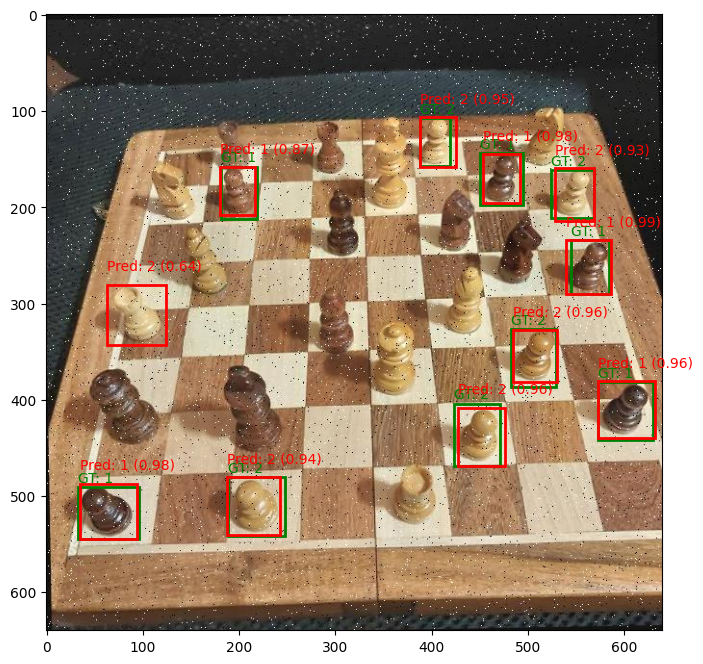

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(model, dataset, idx, device):
    model.eval()
    image, target = dataset[idx]

    # Convert the image to a batch and send it to the device
    image_tensor = image.to(device).unsqueeze(0)

    with torch.no_grad():
        predictions = model(image_tensor)[0]  # Get predictions for the single image

    # Convert tensors back to numpy arrays for visualization
    image_np = image.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image_np)

    # Draw ground truth boxes
    for box, label in zip(target['boxes'], target['labels']):
        x_min, y_min, x_max, y_max = box.cpu().numpy()
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min - 5, f"GT: {label}", color="green")

    # Draw predicted boxes
    for box, score, label in zip(predictions['boxes'], predictions['scores'], predictions['labels']):
        if score > 0.5:  # Display predictions with confidence > 0.5
            x_min, y_min, x_max, y_max = box.cpu().numpy()
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min - 15, f"Pred: {label} ({score:.2f})", color="red")

    plt.show()

# Example: Visualize a sample from the test dataset
visualize_predictions(model, test_dataset, idx=0, device=device)


Installing Libraries

In [14]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 36.6 MB/s eta 0:00:00


**Step 11: Performance Metrics**

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Evaluate the model
def evaluate_model(model, data_loader, device):
    metric = MeanAveragePrecision(iou_type='bbox')  # Explicitly specify IoU type
    model.eval()

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            preds = model(images)
            metric.update(preds, targets)

    return metric.compute()

# Reload dataset and loader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Compute metrics
results = evaluate_model(model, train_loader, device)

# Print available performance metrics
print("Performance Metrics:")
print(f"Mean Average Precision (mAP): {results.get('map', 'N/A'):.4f}")
print(f"Average Precision per Class: {results.get('map_per_class', 'N/A')}")
print(f"Average Precision at IoU=50: {results.get('map_50', 'N/A'):.4f}")
print(f"Average Precision at IoU=75: {results.get('map_75', 'N/A'):.4f}")
print(f"Average Recall: {results.get('mar_100', 'N/A'):.4f}")  # Uses Recall at 100 detections



Performance Metrics:
Mean Average Precision (mAP): 0.7417
Average Precision per Class: -1.0
Average Precision at IoU=50: 0.9817
Average Precision at IoU=75: 0.9482
Average Recall: 0.8028
